In [2]:
import pandas as pd
import numpy as np
import math
import string
import copy
import warnings
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [42]:
test_folds = {}

In [43]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
train_l = list()
val_l = list()
test_l = list()
maxlen = 25
cnt = 0
for train_index, test_index in stfold.split(data['comment'], data['label']):
    cnt += 1
    train = data.iloc[train_index]
    train_x, train_y = train['comment'], train['label']
    tmp = data.iloc[test_index]

    val, test = train_test_split(tmp, test_size=0.5, stratify=tmp['label'])    
    val_x, val_y = val['comment'], val['label']
    test_x, test_y = test['comment'], test['label']    
    
    train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
    val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)
    test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=maxlen)
    
    embed_dim = 128  # Embedding size for each token
    vocab_size = n_word_unique + 1
    test_folds[cnt] = (test_x, test_y)
    
    inputs = layers.Input(shape=(maxlen, ))
    embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length=maxlen)
    x = embedding_layer(inputs)
    x = layers.Bidirectional(layers.GRU(32, return_sequences = True))(x)
    x = layers.Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    x = layers.Dropout(0.1)(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model_path = "sigmoid_models/{itr:04}/".format(itr=cnt)
    checkpoint_path = model_path + "{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    !mkdir sigmoid_models
    !mkdir $model_path
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.009), 
                  loss="binary_crossentropy", metrics=["accuracy", 
                                                  tf.keras.metrics.AUC(name='auc')])
    
    
    #create checkpoint to save model
    #with best validation loss
    model.save_weights(checkpoint_path.format(epoch=0))

    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1,
            save_weights_only=True, save_best_only=True, mode='max')
    
    history = model.fit(
                        train_x, train_y, 
                        batch_size=64, epochs=10, 
                        validation_data=(val_x, val_y),
                        callbacks = [checkpoint]
                        )

    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    
    train_eval = model.evaluate(train_x, train_y)
    val_eval = model.evaluate(val_x, val_y)
    test_eval = model.evaluate(test_x, test_y)
    
    test_l.append(test_eval)
    val_l.append(val_eval)
    train_l.append(train_eval)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.4347 - accuracy: 0.7990 - auc: 0.8723
Epoch 00001: val_auc improved from -inf to 0.93710, saving model to sigmoid_models/0001/0001.ckpt
125/125 [==============================] - 7s 55ms/step - loss: 0.4347 - accuracy: 0.7990 - auc: 0.8723 - val_loss: 0.3030 - val_accuracy: 0.8910 - val_auc: 0.9371
Epoch 2/10
124/125 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9748 - auc: 0.9955
Epoch 00002: val_auc did not improve from 0.93710
125/125 [==============================] - 6s 46ms/step - loss: 0.0755 - accuracy: 0.9747 - auc: 0.9955 - val_loss: 0.4713 - val_accuracy: 0.8470 - val_auc: 0.9214
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9961 - auc: 0.9995
Epoch 00003: val_auc did not improve from 0.93710
125/125 [==============================] - 6s 47ms/step - loss: 0.0146 - accuracy: 0.9961 - auc: 0.9995 - val_loss: 0.5212 - val_accuracy: 0.870

In [44]:
test_l = np.array(test_l)
val_l = np.array(val_l)
train_l = np.array(train_l)

print("test avg loss: ", np.mean(test_l[:, 0]), "+/-" ,np.std(test_l[:, 0]))
print("test avg acc: ", np.mean(test_l[:, 1]),  "+/-" ,np.std(test_l[:, 1]))
print("test avg auc: ", np.mean(test_l[:, 2]),  "+/-" ,np.std(test_l[:, 2]))

print('\n')


print("val avg loss: ", np.mean(val_l[:, 0]), "+/-" ,np.std(val_l[:, 0]))
print("val avg acc: ", np.mean(val_l[:, 1]),  "+/-" ,np.std(val_l[:, 1]))
print("val avg auc: ", np.mean(val_l[:, 2]),  "+/-" ,np.std(val_l[:, 2]))


print('\n')


print("train avg loss: ", np.mean(train_l[:, 0]), "+/-" ,np.std(train_l[:, 0]))
print("train avg acc: ", np.mean(train_l[:, 1]),  "+/-" ,np.std(train_l[:, 1]))
print("train avg auc: ", np.mean(train_l[:, 2]),  "+/-" ,np.std(train_l[:, 2]))

test avg loss:  0.3127451479434967 +/- 0.02140923407524307
test avg acc:  0.8856000065803528 +/- 0.008333069244278632
test avg auc:  0.937699842453003 +/- 0.002823682257236276


val avg loss:  0.3335454523563385 +/- 0.024243541386534322
val avg acc:  0.8803999900817872 +/- 0.011943180883928123
val avg auc:  0.9316841840744019 +/- 0.007499251930913651


train avg loss:  0.12865335494279861 +/- 0.017332458815986326
train avg acc:  0.9512999892234802 +/- 0.007364875125723565
train avg auc:  0.9944977760314941 +/- 0.00041974145249928306


In [46]:
data['word_count'] = data['comment'].apply(lambda a: len(a))

In [47]:
ix_to_word = {v:k for k,v in word_dict_inx.items()}

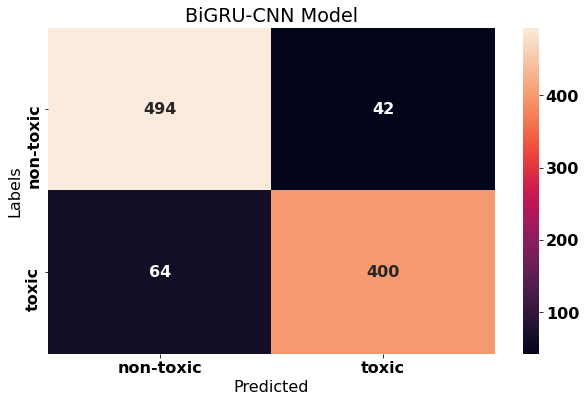

In [49]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
pred = np.array([model.predict(test_folds[5][0]) > 0.5], dtype=int).ravel()
cm = confusion_matrix(test_folds[5][1].values, pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10, 6))

sns.heatmap(cm,
            fmt = 'd',
            annot=True)


ax = plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('Labels')
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.set_title('BiGRU-CNN Model')
plt.show()

In [50]:
ind = np.arange(test.shape[0])
test['word_count'] = test['comment'].apply(lambda a: len(a))
test = test.reset_index(drop=True)
correct = pred==test_y
select_cor = ind[correct]
where_0_c = ind[(correct) & (test_y==0)]
where_0_n = ind[(correct==False) & (test_y==0)]
where_1_c = ind[(correct) & (test_y==1)]
where_1_n = ind[(correct==False) & (test_y==1)]

cor_mean = test.iloc[select_cor]['word_count'].mean(), 
inc_mean = test.iloc[list(set(ind) - set(select_cor))]['word_count'].mean()
cor_std = test.iloc[select_cor]['word_count'].std(), 
inc_std = test.iloc[list(set(ind) - set(select_cor))]['word_count'].std()
print("correct", cor_mean[0], '+/-', cor_std[0])
print("incorrect", inc_mean, '+/-', inc_std)
print('###########################')

cor_mean_0 = test.iloc[where_0_c]['word_count'].mean(), 
inc_mean_0 = test.iloc[where_0_n]['word_count'].mean()
cor_std_0 = test.iloc[where_0_c]['word_count'].std(), 
inc_std_0 = test.iloc[where_0_n]['word_count'].std()
print("correct 0", cor_mean_0[0], '+/-', cor_std_0[0])
print("incorrect 0", inc_mean_0, '+/-', inc_std_0)
print('###########################')


cor_mean_1 = test.iloc[where_1_c]['word_count'].mean(), 
inc_mean_1 = test.iloc[where_1_n]['word_count'].mean()
cor_std_1 = test.iloc[where_1_c]['word_count'].std(), 
inc_std_1 = test.iloc[where_1_n]['word_count'].std()
print("correct 1", cor_mean_1[0], '+/-', cor_std_1[0])
print("incorrect 1", inc_mean_1, '+/-', inc_std_1)

correct 12.20917225950783 +/- 11.458962505850812
incorrect 17.81132075471698 +/- 17.23402681162344
###########################
correct 0 11.793522267206479 +/- 12.81724713343801
incorrect 0 14.714285714285714 +/- 9.577121402352622
###########################
correct 1 12.7225 +/- 9.508760964905955
incorrect 1 19.84375 +/- 20.609150957150156


In [51]:
correct_list = list()
incorrect_list = list()
cor_ind = ind[correct]
incor_ind = ind[list(set(ind) - set(select_cor))]
for cor_com in test.iloc[cor_ind].comment:
    correct_list.extend(cor_com)

for incor_com in test.iloc[incor_ind].comment:
    incorrect_list.extend(incor_com)

cor_top10 = Counter(correct_list).most_common(10)
incor_top10 = Counter(incorrect_list).most_common(10)

In [52]:
print('CORRECT')
for cor in cor_top10:
    print(ix_to_word[cor[0]])
print('###################')
print('INCORRECT')

for incor in incor_top10:
    print(ix_to_word[incor[0]])

CORRECT
არ
ეს
რა
უნდა
იყო
ვერ
ეგ
ამ
ჩვენი
არა
###################
INCORRECT
არ
რა
ამ
უნდა
საქართველო
რუსეთი
იყო
ჩვენი
არა
მეი


In [53]:
plt.savefig('bigru-cnn.png')

<Figure size 432x288 with 0 Axes>